In [7]:
import nrrd
import nibabel as nib
import numpy as np
import os
from pathlib import Path
import ants

# files
template_file = '/Users/mahdi/stage-2022-mahdi/src/average_template_25.nrrd'
template_file_nifti = '/Users/mahdi/stage-2022-mahdi/src/average_template_25_nifti.nii.gz'
template_ras_file = "/Users/mahdi/stage-2022-mahdi/src/average_template_25_nifti_manualRAS.nii.gz"

# avgt settings
res_avgt_mm = 70 / 1e3
avgt_offset = np.array([-5.675, -8.79448, -8.450335, 0])

# allen settings 
res = 25

# load the nrrd
vol, header = nrrd.read(template_file)

# Preparing the affine to align the template in the RAS+
r_mm = res / 1e3
affine = np.array([[0, 0, r_mm, 0],
                   [-r_mm, 0, 0, 0],
                   [0, -r_mm, 0, 0],
                   [0, 0, 0, 1]])

# Saving the nrrd volume to nifti
img = nib.Nifti1Image(vol, affine)
nib.save(img, template_file_nifti)

In [8]:

# Load and manually transform the template
vol = nib.load(template_file_nifti).get_fdata()

vol_ras = np.moveaxis(vol, (0,1,2), (1,2,0))
vol_ras = np.flip(vol_ras, axis=2)
vol_ras = np.flip(vol_ras, axis=1)

# Scale to avgt resolution
affine = np.eye(4) * res_avgt_mm

# Save the manual rearanged volume to nifti 
img_ras = nib.Nifti1Image(vol_ras, affine)
nib.save(img_ras, template_ras_file)

print(affine)

[[0.07 0.   0.   0.  ]
 [0.   0.07 0.   0.  ]
 [0.   0.   0.07 0.  ]
 [0.   0.   0.   0.07]]


In [2]:
import nibabel as nib
import ants 
#  load reference (fixed)
avgt = nib.load('/Users/mahdi/stage-2022-mahdi/src/AVGT.nii.gz')
ref_vol = avgt.get_fdata()
print(avgt.affine)

# load allen (moving)
allen = nib.load('/Users/mahdi/stage-2022-mahdi/src/average_template_25_nifti_manualRAS.nii.gz')
allen_vol = allen.get_fdata()

# convert to float
allen_vol = allen_vol.astype(float)
ref_vol = ref_vol.astype(float)

# create ants image
fixed = ants.from_numpy( ref_vol ).resample_image((164, 212, 158),1,0)
moving = ants.from_numpy( allen_vol ).resample_image((164, 212, 158),1,0)

[[ 0.06999999  0.          0.         -5.67500019]
 [ 0.          0.06999999  0.         -8.79448032]
 [ 0.          0.          0.06999999 -8.45033455]
 [ 0.          0.          0.          1.        ]]


FileNotFoundError: No such file or no access: '/Users/mahdi/stage-2022-mahdi/src/average_template_25_nifti_manualRAS.nii.gz'

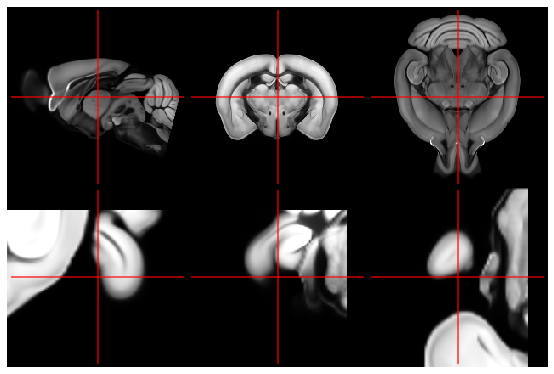

In [10]:
# original plot
fixed.plot_ortho_double(moving)

In [11]:
# define a transformation
mytx = ants.registration(fixed=fixed , moving=moving, type_of_transform='SyN' )

# apply the transformation
warped_moving = ants.apply_transforms(fixed=fixed, moving=moving, 
                                          transformlist=mytx['fwdtransforms'])

[[0.07 0.   0.   0.  ]
 [0.   0.07 0.   0.  ]
 [0.   0.   0.07 0.  ]
 [0.   0.   0.   0.07]]
[[ 0.07      0.        0.       -5.675   ]
 [ 0.        0.07      0.       -8.79448 ]
 [ 0.        0.        0.07     -8.450335]
 [ 0.        0.        0.        0.07    ]]


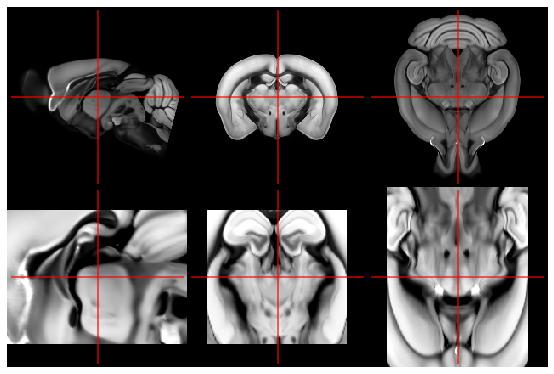

In [12]:
print(affine)

# change the image origin to match with avgt origin in mi-brain
affine_offset = affine.copy()
affine_offset[:,3] = affine_offset[:,3] + avgt_offset

print(affine_offset)

# plot result
fixed.plot_ortho_double(warped_moving)

In [13]:
# Convert to numpy array
warped_vol = warped_moving.numpy()

# Saving the new volume (nifti)
img = nib.Nifti1Image(warped_vol, affine_offset)
nib.save(img, '/Users/mahdi/stage-2022-mahdi/src/average_template_25_nifti_manualRAS_reg.nii.gz.nii.gz')